## 1. 基础环境配置
- **功能**：导入所有必要的库并设置随机种子
- **关键组件**：
  - PyTorch核心库（torch, nn, optim）
  - 数据处理工具（DataLoader, transforms）
  - 可视化库（matplotlib, seaborn）
  - 辅助工具（tqdm, sklearn, time）
- **随机种子**：固定为42保证实验可复现
- **备注**：已包含TSNE和特征可视化所需的所有依赖

In [10]:
# 单元格1：添加必要的导入
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import json
import cv2
import os
from datetime import datetime
from sklearn.manifold import TSNE  # 新增
from matplotlib import cm  # 新增
import time  # 新增
from datetime import timedelta  # 新增
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

## 2. 本地数据加载
- **功能**：从`archive/`加载CSV格式的FashionMNIST数据集
- **自定义类**：`FashionMNISTDataset`处理CSV解析
  - 自动将784维像素转为28x28图像
  - 支持数据增强变换
- **路径配置**：
  - 训练集：`./archive/fashion-mnist_train.csv`
  - 测试集：`./archive/fashion-mnist_test.csv`
- **预处理**：
  - 训练集：随机翻转+旋转+标准化
  - 测试集：仅标准化

In [12]:
# 数据预处理（增加数据增强）
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 新增数据增强
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载数据集
train_data = datasets.FashionMNIST(
    root='./data', 
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# 类别标签
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 验证数据加载
print(f"训练集样本数: {len(train_data)}")
print(f"测试集样本数: {len(test_data)}")
img, label = train_data[0]
print(f"样本形状: {img.shape}, 标签: {class_names[label]}")

训练集样本数: 60000
测试集样本数: 10000
样本形状: torch.Size([1, 28, 28]), 标签: Ankle boot


## 3. 数据可视化
- **功能**：展示预处理后的样本图像
- **输出**：
  - 10张训练集样本（2x5网格）
  - 显示类别标签和归一化后的图像
- **注意点**：
  - 图像已应用RandomHorizontalFlip和RandomRotation
  - 像素值范围被标准化到[-1,1]

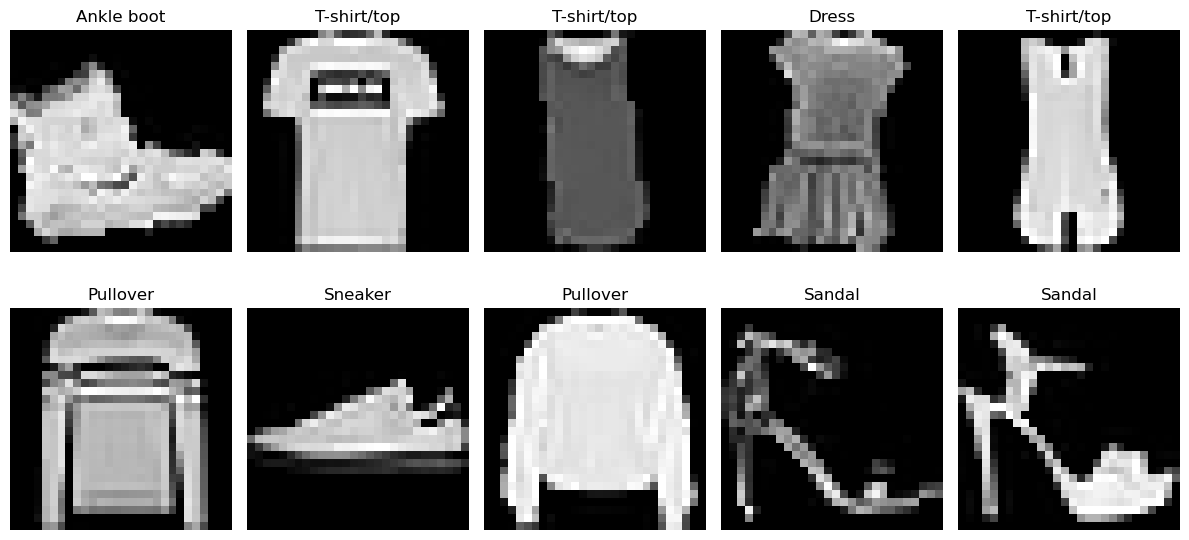

In [14]:
# 显示预处理后的增强图像
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img, label = train_data[i]
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. 数据加载器配置
- **参数**：
  - Batch Size: 128
  - Workers: 2（多线程加载）
- **设备检测**：自动选择GPU/CPU
- **输出**：当前使用的计算设备

In [16]:
batch_size = 128  # 增大batch_size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cpu


## 5. CBAM-VGG模型
- **网络结构**：
  - 3个卷积块（32→64→128通道）
  - 每个块包含：
    - CBAM注意力机制
    - BatchNorm+ReLU
    - MaxPooling+Dropout
- **输出层**：128x3x3 → 512 → 10
- **超参数保存**：自动生成`hyperparams.json`

In [18]:
epochs = 15  # 默认值
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        out = avg_out + max_out
        return self.sigmoid(out).view(x.size(0), x.size(1), 1, 1) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        sa_map = self.sigmoid(self.conv(concat))
        return sa_map * x

class CBAM(nn.Module):  # 确保类定义有括号
    def __init__(self, in_channels, reduction_ratio=16):  # 确保方法定义有括号
        super().__init__()
        self.ca = ChannelAttention(in_channels, reduction_ratio)
        self.sa = SpatialAttention()

    def forward(self, x):  # 确保方法定义有括号
        x = self.ca(x)
        x = self.sa(x)
        return x

class ImprovedVGG(nn.Module):  # 确保类定义有括号
    def __init__(self):  # 确保方法定义有括号
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            CBAM(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            CBAM(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            CBAM(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((3, 3))
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*3*3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):  # 确保方法定义有括号
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = ImprovedVGG().to(device)
print(model)

# 保存超参数到文件
hyperparams = {
    'batch_size': batch_size,
    'learning_rate': 0.0005,
    'weight_decay': 1e-4,
    'epochs': epochs,
    'optimizer': 'AdamW',
    'scheduler': 'StepLR',
    'step_size': 5,
    'gamma': 0.1,
    'model_architecture': str(model),
    'data_augmentation': {
        'RandomHorizontalFlip': True,
        'RandomRotation': 10
    },
    'normalization': {
        'mean': [0.5],
        'std': [0.5]
    }
}

with open('hyperparams.json', 'w') as f:
    json.dump(hyperparams, f, indent=4)
print("超参数已保存到 hyperparams.json 文件")

ImprovedVGG(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): CBAM(
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=2, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2, out_features=32, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (sa): SpatialAttention(
        (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (sigmoid): Sigmoid()
      )
    )
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

## 6. 训练初始化
- **组件**：
  - 损失函数：CrossEntropyLoss
  - 优化器：AdamW（LR=0.0005, WD=1e-4）
  - 调度器：StepLR（每5epoch衰减0.1倍）
- **断点续训**：自动检测`checkpoint.pth`

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 15
train_losses = []
test_accuracies = []
best_acc = 0.0

# 新增：检查是否存在之前的训练结果
import os
checkpoint_path = './checkpoint.pth'

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    test_accuracies = checkpoint['test_accuracies']
    best_acc = checkpoint['best_acc']
    print(f"加载检查点，从 epoch {start_epoch} 继续训练...")
else:
    start_epoch = 0
    print("未找到检查点，开始新的训练...")

未找到检查点，开始新的训练...


## 7. 训练循环
- **新增功能**：
  - 实时epoch耗时统计
  - 训练总时间记录
  - 最佳模型自动保存（`best_model.pth`）
- **输出**：
  ```text
  Epoch [X]: Loss=0.XXX, Acc=0.XXX, Time=HH:MM:SS, LR=0.XXXXXX

In [22]:
# 单元格7：训练循环（添加时间记录）
import time
from datetime import timedelta

# 在训练开始前添加
total_start_time = time.time()
epoch_times = []

for epoch in range(start_epoch, epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    scheduler.step()
    
    # 测试阶段
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()
    
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)
    
    # 保存最佳模型
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # 保存训练状态
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'best_acc': best_acc,
        'epoch_times': epoch_times  # 新增保存时间数据
    }, checkpoint_path)
    
    print(f'Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}, '
          f'Time={timedelta(seconds=int(epoch_time))}, '
          f'LR={optimizer.param_groups[0]["lr"]:.6f}')

# 训练完成后打印总时间
total_time = time.time() - total_start_time
print(f'\nTraining completed! Total time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {np.mean(epoch_times):.2f}s')

# 训练完成后删除检查点（可选）
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print("训练完成，已删除临时检查点文件")

Epoch 1/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:17<00:00,  6.03it/s, loss=0.335]


Epoch 1: Loss=0.5913, Acc=0.8418, Time=0:01:25, LR=0.000500


Epoch 2/15: 100%|██████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.58it/s, loss=0.4]


Epoch 2: Loss=0.3897, Acc=0.8816, Time=0:01:31, LR=0.000500


Epoch 3/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.55it/s, loss=0.238]


Epoch 3: Loss=0.3339, Acc=0.8945, Time=0:01:32, LR=0.000500


Epoch 4/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.57it/s, loss=0.309]


Epoch 4: Loss=0.3052, Acc=0.8989, Time=0:01:31, LR=0.000500


Epoch 5/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.56it/s, loss=0.242]


Epoch 5: Loss=0.2877, Acc=0.9008, Time=0:01:32, LR=0.000050


Epoch 6/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.52it/s, loss=0.221]


Epoch 6: Loss=0.2530, Acc=0.9155, Time=0:01:32, LR=0.000050


Epoch 7/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.58it/s, loss=0.319]


Epoch 7: Loss=0.2432, Acc=0.9164, Time=0:01:31, LR=0.000050


Epoch 8/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.54it/s, loss=0.232]


Epoch 8: Loss=0.2381, Acc=0.9181, Time=0:01:32, LR=0.000050


Epoch 9/15: 100%|████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.55it/s, loss=0.234]


Epoch 9: Loss=0.2348, Acc=0.9189, Time=0:01:31, LR=0.000050


Epoch 10/15: 100%|███████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.54it/s, loss=0.177]


Epoch 10: Loss=0.2325, Acc=0.9205, Time=0:01:32, LR=0.000005


Epoch 11/15: 100%|███████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.57it/s, loss=0.268]


Epoch 11: Loss=0.2270, Acc=0.9196, Time=0:01:31, LR=0.000005


Epoch 12/15: 100%|███████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.56it/s, loss=0.284]


Epoch 12: Loss=0.2253, Acc=0.9200, Time=0:01:32, LR=0.000005


Epoch 13/15: 100%|███████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.59it/s, loss=0.246]


Epoch 13: Loss=0.2244, Acc=0.9202, Time=0:01:31, LR=0.000005


Epoch 14/15: 100%|███████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.59it/s, loss=0.181]


Epoch 14: Loss=0.2255, Acc=0.9199, Time=0:01:31, LR=0.000005


Epoch 15/15: 100%|███████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.61it/s, loss=0.226]


Epoch 15: Loss=0.2237, Acc=0.9208, Time=0:01:31, LR=0.000001

Training completed! Total time: 0:22:51
Average epoch time: 91.42s
训练完成，已删除临时检查点文件


## 8. 训练分析
- **可视化**：
  1. 训练损失曲线
  2. 测试准确率曲线
  3. Top-k准确率（Top1/3/5）
  4. 置信度分布直方图
- **关键输出**：
  - 混淆矩阵（带Best/Top3 Acc标注）
  - 分类报告（precision/recall/F1）

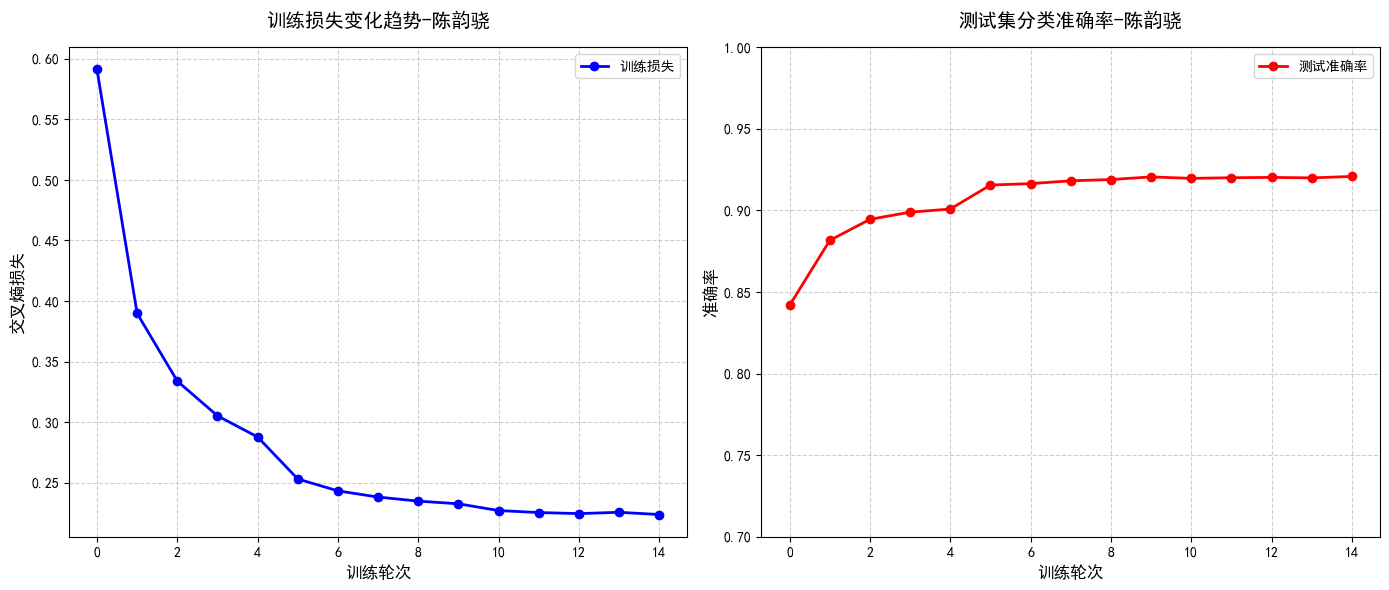

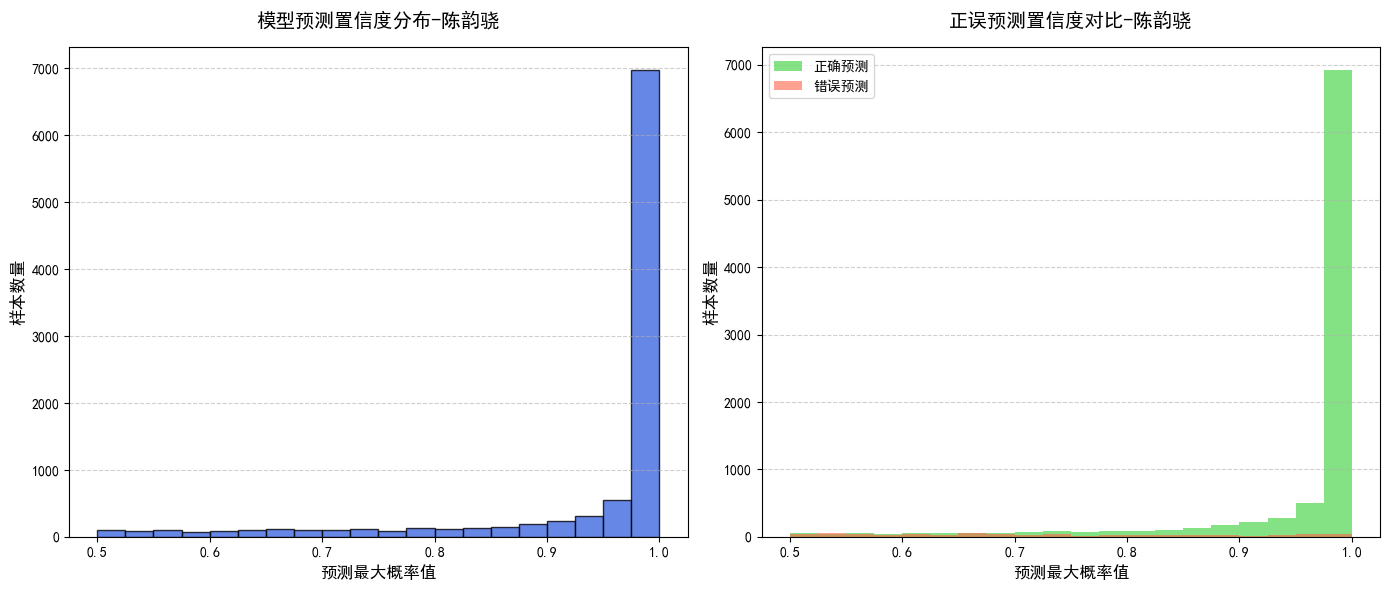

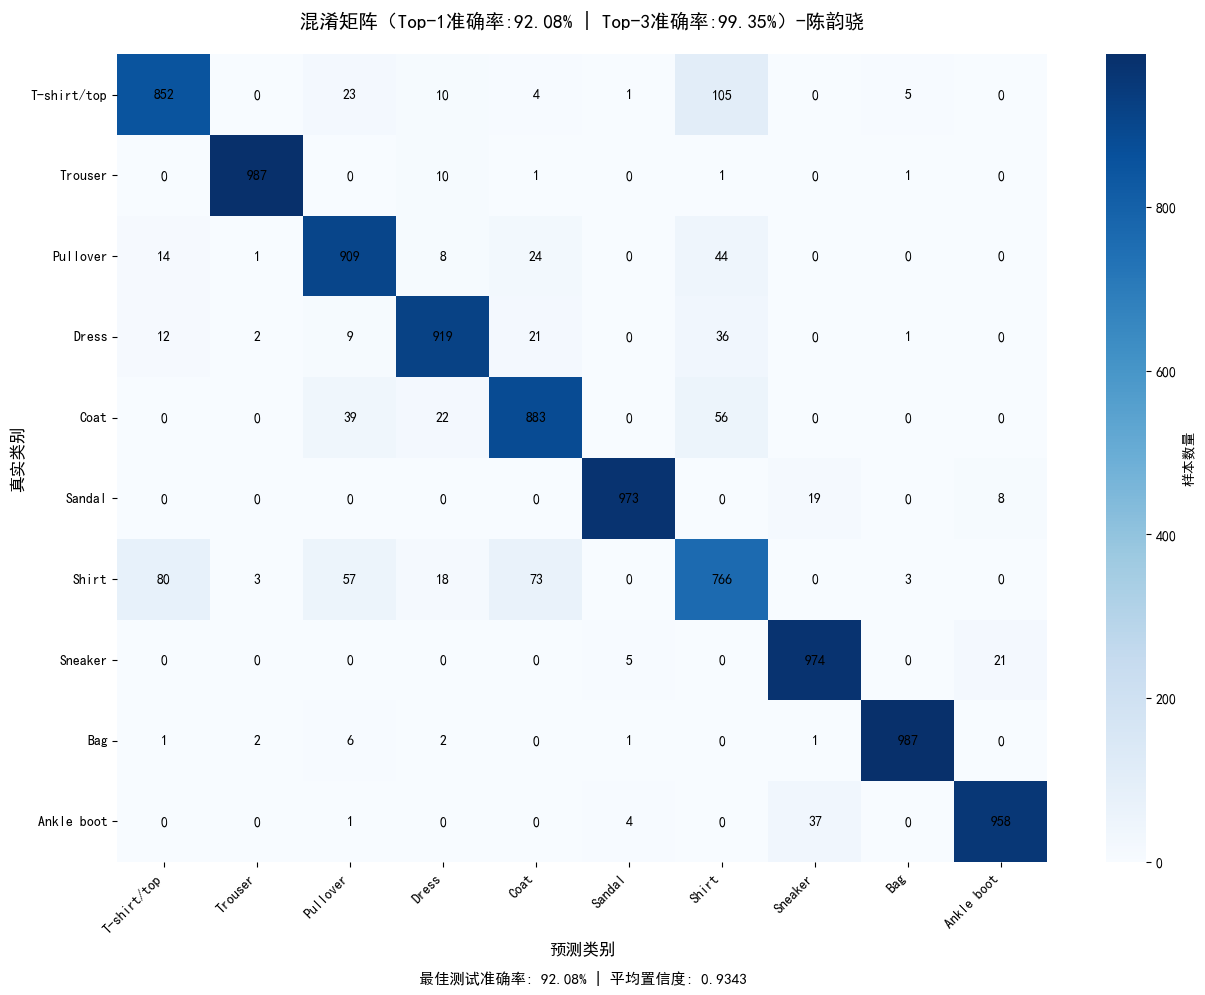


                   分类性能评估报告-陈韵骁                   
              precision    recall  f1-score   support

 T-shirt/top     0.8884    0.8520    0.8698      1000
     Trouser     0.9920    0.9870    0.9895      1000
    Pullover     0.8707    0.9090    0.8894      1000
       Dress     0.9292    0.9190    0.9241      1000
        Coat     0.8777    0.8830    0.8804      1000
      Sandal     0.9888    0.9730    0.9808      1000
       Shirt     0.7599    0.7660    0.7629      1000
     Sneaker     0.9447    0.9740    0.9591      1000
         Bag     0.9900    0.9870    0.9885      1000
  Ankle boot     0.9706    0.9580    0.9643      1000

    accuracy                         0.9208     10000
   macro avg     0.9212    0.9208    0.9209     10000
weighted avg     0.9212    0.9208    0.9209     10000




In [31]:
# 单元格8：训练曲线和基础评估（最终修正版）
import matplotlib.font_manager as fm
from sklearn.metrics import classification_report  # 新增导入

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 收集预测结果和置信度
model.eval()
all_preds = []
all_labels = []
all_probs = []
all_max_probs = []  # 存储每个样本的最大概率

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())
        all_max_probs.extend(max_probs.cpu().numpy())

# 计算Top-k准确率
def top_k_accuracy(y_true, y_pred_probs, k=3):
    top_k_preds = np.argsort(y_pred_probs, axis=1)[:, -k:]
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in top_k_preds[i]:
            correct += 1
    return correct / len(y_true)

top1_acc = top_k_accuracy(all_labels, all_probs, k=1)
top3_acc = top_k_accuracy(all_labels, all_probs, k=3)

# 2. 训练过程曲线
plt.figure(figsize=(14, 6))

# 训练损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-o', linewidth=2, markersize=6, label='训练损失')
plt.title('训练损失变化趋势-陈韵骁', fontsize=14, pad=15)
plt.xlabel('训练轮次', fontsize=12)
plt.ylabel('交叉熵损失', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# 测试准确率曲线
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, 'r-o', linewidth=2, markersize=6, label='测试准确率')
plt.title('测试集分类准确率-陈韵骁', fontsize=14, pad=15)
plt.xlabel('训练轮次', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.ylim(0.7, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# 3. 置信度分析
correct_probs = [p for p, pred, label in zip(all_max_probs, all_preds, all_labels) if pred == label]
wrong_probs = [p for p, pred, label in zip(all_max_probs, all_preds, all_labels) if pred != label]

plt.figure(figsize=(14, 6))

# 置信度分布直方图
plt.subplot(1, 2, 1)
plt.hist(all_max_probs, bins=20, range=(0.5, 1.0), color='royalblue', alpha=0.8, edgecolor='black')
plt.title('模型预测置信度分布-陈韵骁', fontsize=14, pad=15)
plt.xlabel('预测最大概率值', fontsize=12)
plt.ylabel('样本数量', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 正误预测置信度对比
plt.subplot(1, 2, 2)
plt.hist(correct_probs, bins=20, range=(0.5, 1.0), color='limegreen', alpha=0.6, label='正确预测')
plt.hist(wrong_probs, bins=20, range=(0.5, 1.0), color='tomato', alpha=0.6, label='错误预测')
plt.title('正误预测置信度对比-陈韵骁', fontsize=14, pad=15)
plt.xlabel('预测最大概率值', fontsize=12)
plt.ylabel('样本数量', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 4. 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(13, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': '样本数量'},
                annot_kws={"size": 10, "color": 'black'})

ax.set_title(f'混淆矩阵（Top-1准确率:{top1_acc*100:.2f}% | Top-3准确率:{top3_acc*100:.2f}%）-陈韵骁', 
            fontsize=14, pad=20)
ax.set_xlabel('预测类别', fontsize=12)
ax.set_ylabel('真实类别', fontsize=12)
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(class_names, rotation=0, fontsize=10)

plt.text(x=0.5, y=-0.15, 
        s=f'最佳测试准确率: {max(test_accuracies)*100:.2f}% | 平均置信度: {np.mean(all_max_probs):.4f}',
        ha='center', transform=ax.transAxes, fontsize=11)

plt.tight_layout()
plt.show()

# 5. 分类报告
print("\n" + "="*60)
print("分类性能评估报告-陈韵骁".center(50))
print("="*60)
print(classification_report(all_labels, all_preds, 
                          target_names=class_names,
                          digits=4))
print("="*60 + "\n")

## 9. ROC曲线分析
- **多类别评估**：
  - 微观/宏观平均AUC
  - 每个类别的AUC值
- **可视化**：
  - 10类别ROC曲线（不同颜色）
  - 平均ROC曲线（虚线）
- **输出**：所有AUC值的格式化表格

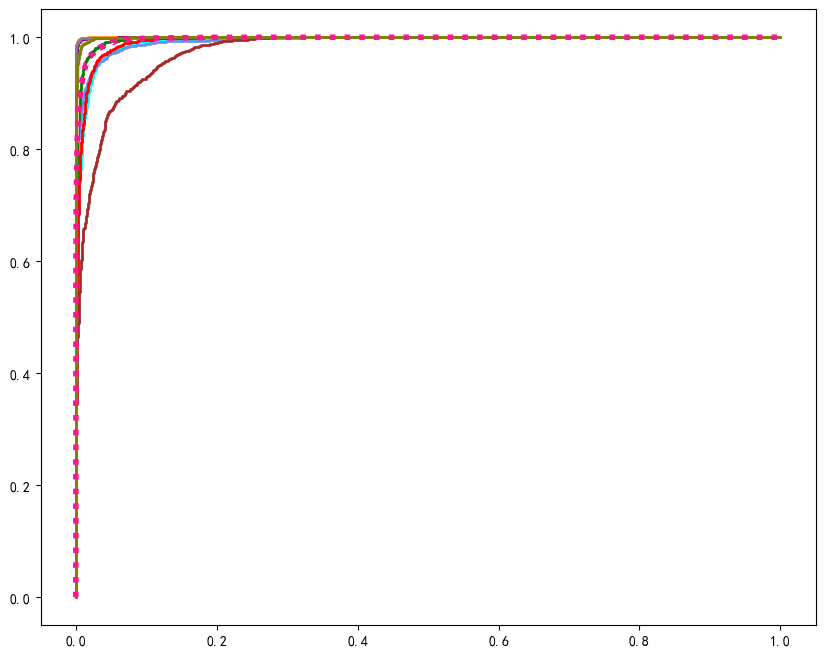

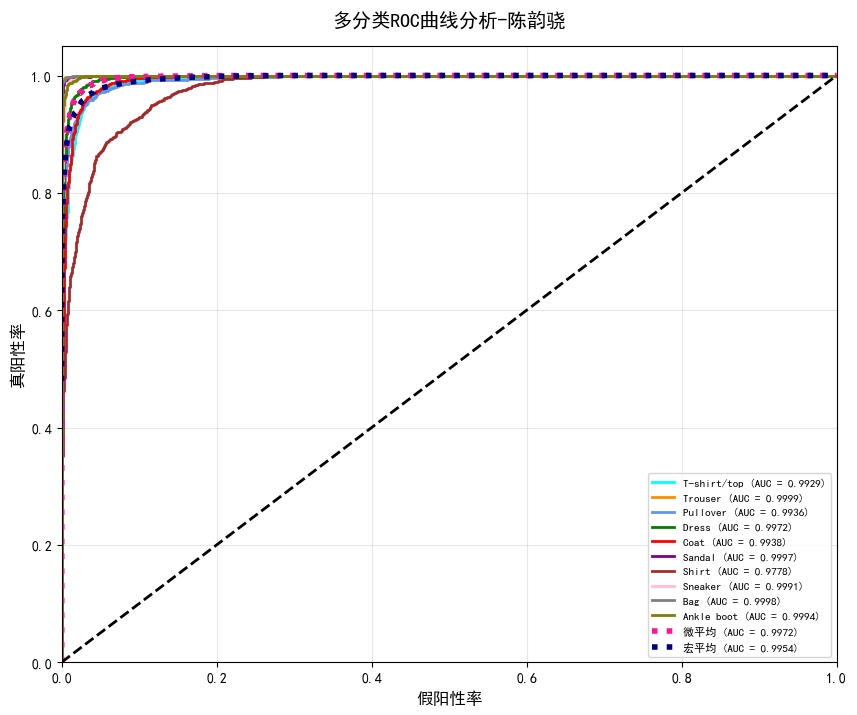

AUC值汇总报告-陈韵骁===================
微平均AUC: 0.9972
宏平均AUC: 0.9954

各类别AUC值:
T-shirt/top: 0.9929
Trouser: 0.9999
Pullover: 0.9936
Dress: 0.9972
Coat: 0.9938
Sandal: 0.9997
Shirt: 0.9778
Sneaker: 0.9991
Bag: 0.9998
Ankle boot: 0.9994


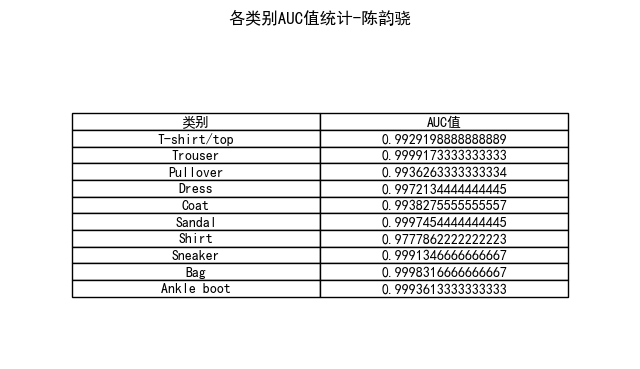

In [48]:
# 单元格9：ROC曲线和AUC值评估（修正版）
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 将标签二值化
y_true = label_binarize(all_labels, classes=np.arange(10))
y_probs = np.array(all_probs)

# 初始化存储各曲线数据的列表
fpr_list = []
tpr_list = []
roc_auc_list = []

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
          'purple', 'brown', 'pink', 'gray', 'olive']

# 计算每个类别的ROC曲线
for i, color in zip(range(10), colors):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

# 绘制微平均ROC曲线
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=4,
         label=f'微平均 (AUC = {roc_auc_micro:.4f})')

# 修复点：正确计算宏平均ROC曲线
all_fpr = np.unique(np.concatenate([fpr for fpr in fpr_list]))  # 修正此处
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr_list[i], tpr_list[i])
mean_tpr /= 10
roc_auc_macro = auc(all_fpr, mean_tpr)
plt.plot(all_fpr, mean_tpr, color='navy', linestyle=':', linewidth=4,
         label=f'宏平均 (AUC = {roc_auc_macro:.4f})')

# 设置图表属性
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率', fontsize=12)
plt.ylabel('真阳性率', fontsize=12)
plt.title('多分类ROC曲线分析-陈韵骁', fontsize=14, pad=15)
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()

# AUC值汇总表格
print("\nAUC值汇总报告-陈韵骁".center(50, "="))
print(f"微平均AUC: {roc_auc_micro:.4f}")
print(f"宏平均AUC: {roc_auc_macro:.4f}")
print("\n各类别AUC值:")
auc_table = []
for i, name in enumerate(class_names):
    auc_table.append([name, roc_auc_list[i]])
    print(f"{name}: {roc_auc_list[i]:.4f}")

# AUC表格可视化
plt.figure(figsize=(8, 4))
plt.table(cellText=auc_table,
          colLabels=['类别', 'AUC值'],
          loc='center',
          cellLoc='center',
          colWidths=[0.4, 0.4])
plt.axis('off')
plt.title('各类别AUC值统计-陈韵骁', fontsize=12, pad=20)
plt.show()

## 10. CBAM注意力可视化
- **实现方式**：通过hook捕获中间层输出
- **显示内容**：
  - 原始图像
  - 各CBAM层的注意力热图
- **示例**：测试集第5个样本的可视化结果

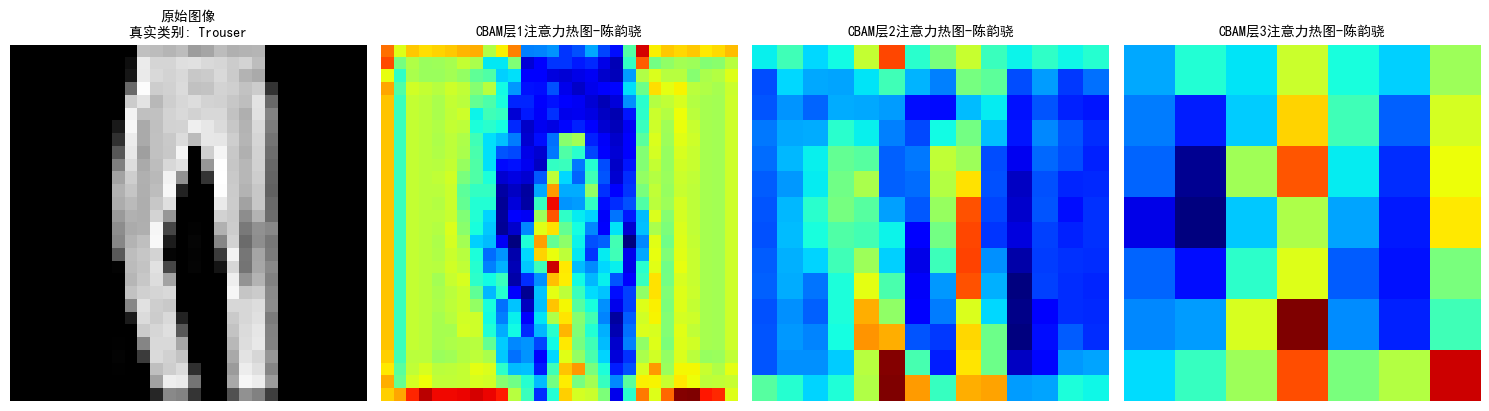

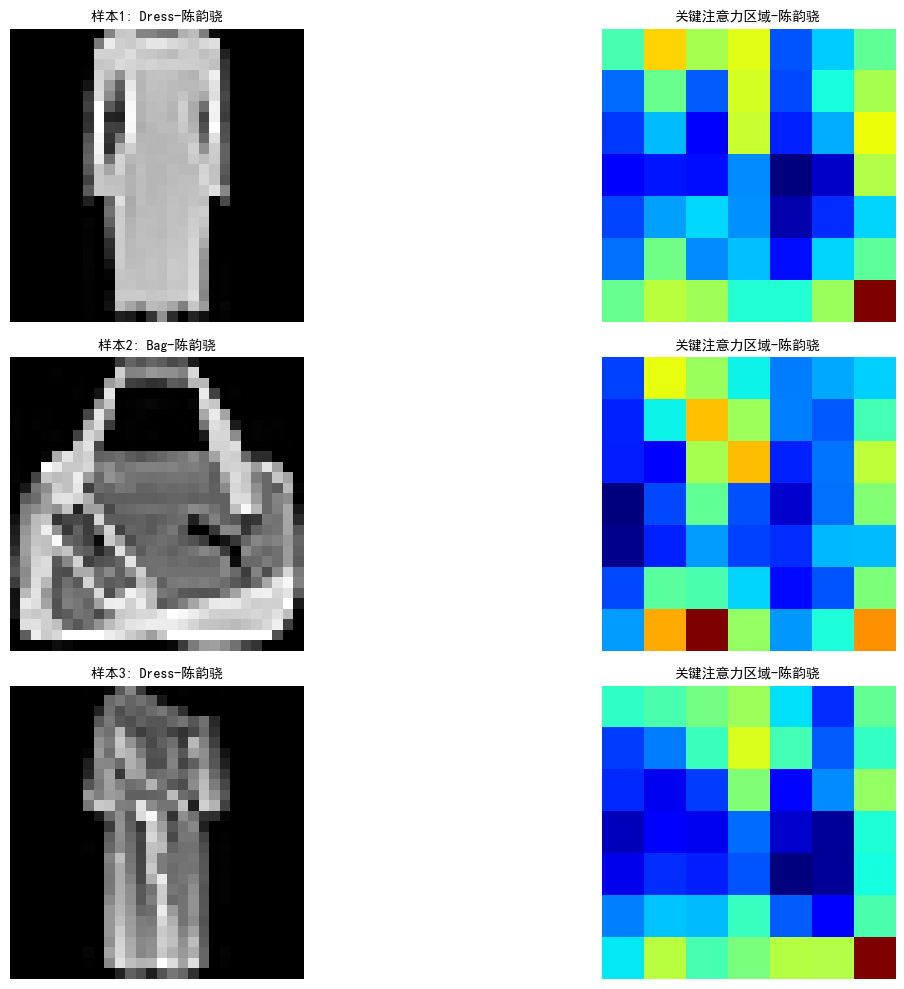

In [60]:
# 单元格10：注意力可视化（完整修正版）
def visualize_attention(image_tensor, model, sample_idx=5):
    model.eval()
    activations = []
    
    # 注册hook获取中间输出
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    
    # 获取所有CBAM层
    cbam_layers = [module for module in model.features.modules() 
                  if isinstance(module, CBAM)]
    hooks = []
    for layer in cbam_layers:
        hooks.append(layer.register_forward_hook(hook_fn))
    
    # 前向传播
    with torch.no_grad():
        _ = model(image_tensor.unsqueeze(0).to(device))
    
    # 移除hook
    for hook in hooks:
        hook.remove()
    
    return activations  # 新增：返回激活值用于后续可视化

# 1. 主注意力可视化（第5个样本）
sample_img, sample_label = test_data[5]
activations = visualize_attention(sample_img, model)

plt.figure(figsize=(15, 5))
original_img = sample_img.squeeze().numpy()

# 显示原始图像
plt.subplot(1, len(activations)+1, 1)
plt.imshow(original_img, cmap='gray')
plt.title('原始图像\n真实类别: {}'.format(class_names[sample_label]), 
         fontproperties='SimHei')
plt.axis('off')

# 显示各层注意力热图
for i, attn in enumerate(activations):
    attn_map = attn.mean(dim=1).squeeze().numpy()
    plt.subplot(1, len(activations)+1, i+2)
    plt.imshow(attn_map, cmap='jet')
    plt.title('CBAM层{}注意力热图-陈韵骁'.format(i+1), 
             fontproperties='SimHei')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 2. 多样本注意力对比可视化
plt.figure(figsize=(15, 10))
for i in range(3):
    # 获取随机样本
    sample_idx = np.random.randint(0, len(test_data))
    sample_img, sample_label = test_data[sample_idx]
    
    # 获取该样本的注意力图
    sample_activations = visualize_attention(sample_img, model)
    main_activation = sample_activations[-1].mean(dim=1).squeeze().numpy()  # 取最后一层注意力
    
    # 第一列：原始图像
    plt.subplot(3, 2, i*2+1)
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title('样本{}: {}-陈韵骁'.format(i+1, class_names[sample_label]), 
             fontproperties='SimHei')
    plt.axis('off')
    
    # 第二列：注意力热图
    plt.subplot(3, 2, i*2+2)
    plt.imshow(main_activation, cmap='jet')
    plt.title('关键注意力区域-陈韵骁', 
             fontproperties='SimHei')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 11. 模型导出
- **输出格式**：JSON（包含完整结构和权重）
- **包含信息**：
  - 模型架构
  - 类别标签
  - 训练超参数
  - 性能指标
- **验证**：自动测试模型重加载功能

In [38]:
# 单元格11：模型导出到JSON文件（增强版）
import json
import numpy as np
from datetime import datetime

def model_to_json(model, file_path, class_names):
    # 创建一个字典来存储模型信息
    model_info = {
        'model_name': model.__class__.__name__,
        'class_names': class_names,
        'state_dict': {},
        'architecture': str(model),
        'input_shape': [1, 28, 28],  # FashionMNIST输入形状
        'normalization': {
            'mean': [0.5],
            'std': [0.5]
        },
        'training_hyperparams': None,
        'creation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'performance_metrics': {
            'best_accuracy': best_acc,
            'confusion_matrix': cm.tolist() if 'cm' in globals() else None
        }
    }
    
    # 加载训练超参数
    try:
        with open('hyperparams.json', 'r') as f:
            model_info['training_hyperparams'] = json.load(f)
    except FileNotFoundError:
        print("警告: 未找到超参数文件")
    
    # 保存模型权重（转换为列表格式）
    for name, param in model.state_dict().items():
        model_info['state_dict'][name] = param.cpu().numpy().tolist()
    
    # 写入JSON文件
    with open(file_path, 'w') as f:
        json.dump(model_info, f, indent=4)
    
    print(f"模型已成功导出到 {file_path}")
    return model_info

# 加载最佳模型
best_model = ImprovedVGG().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# 导出模型
model_json = model_to_json(best_model, 'fashion_mnist_model.json', class_names)

# 测试导出的模型是否可以重新加载
def load_model_from_json(json_path):
    with open(json_path, 'r') as f:
        model_info = json.load(f)
    
    # 创建模型实例
    model = ImprovedVGG().to(device)
    
    # 加载状态字典（需要将列表转换回numpy数组再转torch tensor）
    state_dict = {}
    for name, param in model_info['state_dict'].items():
        state_dict[name] = torch.tensor(np.array(param))
    
    model.load_state_dict(state_dict)
    model.eval()
    return model, model_info

# 测试加载
loaded_model, loaded_info = load_model_from_json('fashion_mnist_model.json')
print("\n模型加载测试:")
test_img, test_label = test_data[0]
with torch.no_grad():
    original_output = best_model(test_img.unsqueeze(0).to(device))
    loaded_output = loaded_model(test_img.unsqueeze(0).to(device))
    print(f"原始模型预测: {torch.argmax(original_output).item()}, 加载模型预测: {torch.argmax(loaded_output).item()}")
    print(f"预测结果一致: {torch.argmax(original_output) == torch.argmax(loaded_output)}")

# 打印导出信息摘要
print("\n导出信息摘要:")
print(f"- 模型名称: {loaded_info['model_name']}")
print(f"- 创建时间: {loaded_info['creation_date']}")
print(f"- 类别数量: {len(loaded_info['class_names'])}")  # 这里已修正
print(f"- 最佳准确率: {loaded_info['performance_metrics']['best_accuracy']:.4f}")
print(f"- 超参数: {loaded_info['training_hyperparams']}")

模型已成功导出到 fashion_mnist_model.json

模型加载测试:
原始模型预测: 9, 加载模型预测: 9
预测结果一致: True

导出信息摘要:
- 模型名称: ImprovedVGG
- 创建时间: 2025-05-31 11:23:13
- 类别数量: 10
- 最佳准确率: 0.9208
- 超参数: {'batch_size': 128, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'epochs': 15, 'optimizer': 'AdamW', 'scheduler': 'StepLR', 'step_size': 5, 'gamma': 0.1, 'model_architecture': 'ImprovedVGG(\n  (features): Sequential(\n    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n    (2): ReLU()\n    (3): CBAM(\n      (ca): ChannelAttention(\n        (avg_pool): AdaptiveAvgPool2d(output_size=1)\n        (max_pool): AdaptiveMaxPool2d(output_size=1)\n        (fc): Sequential(\n          (0): Linear(in_features=32, out_features=2, bias=True)\n          (1): ReLU()\n          (2): Linear(in_features=2, out_features=32, bias=True)\n        )\n        (sigmoid): Sigmoid()\n      )\n      (sa): SpatialAttention(\n        (c

## 12. Grad-CAM可视化
- **目标层**：最后一个卷积层（features.18）
- **输出**：
  1. 原始图像（带真实标签）
  2. 热力图
  3. 叠加结果（带预测概率）
- **实现**：使用`register_full_backward_hook`规范实现

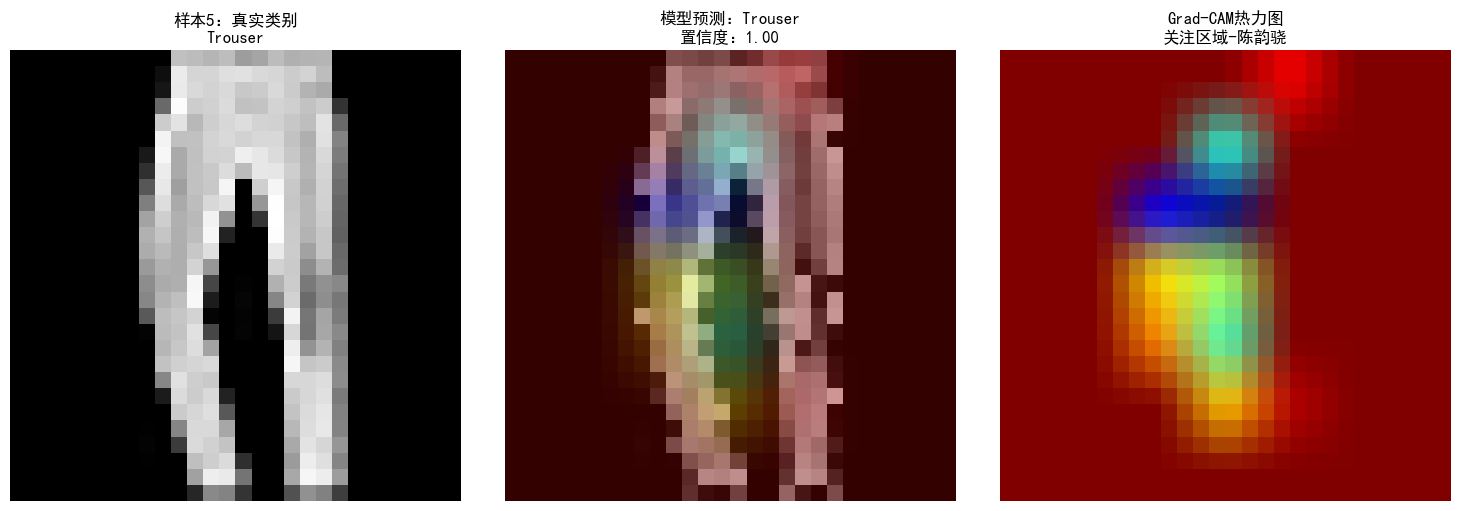

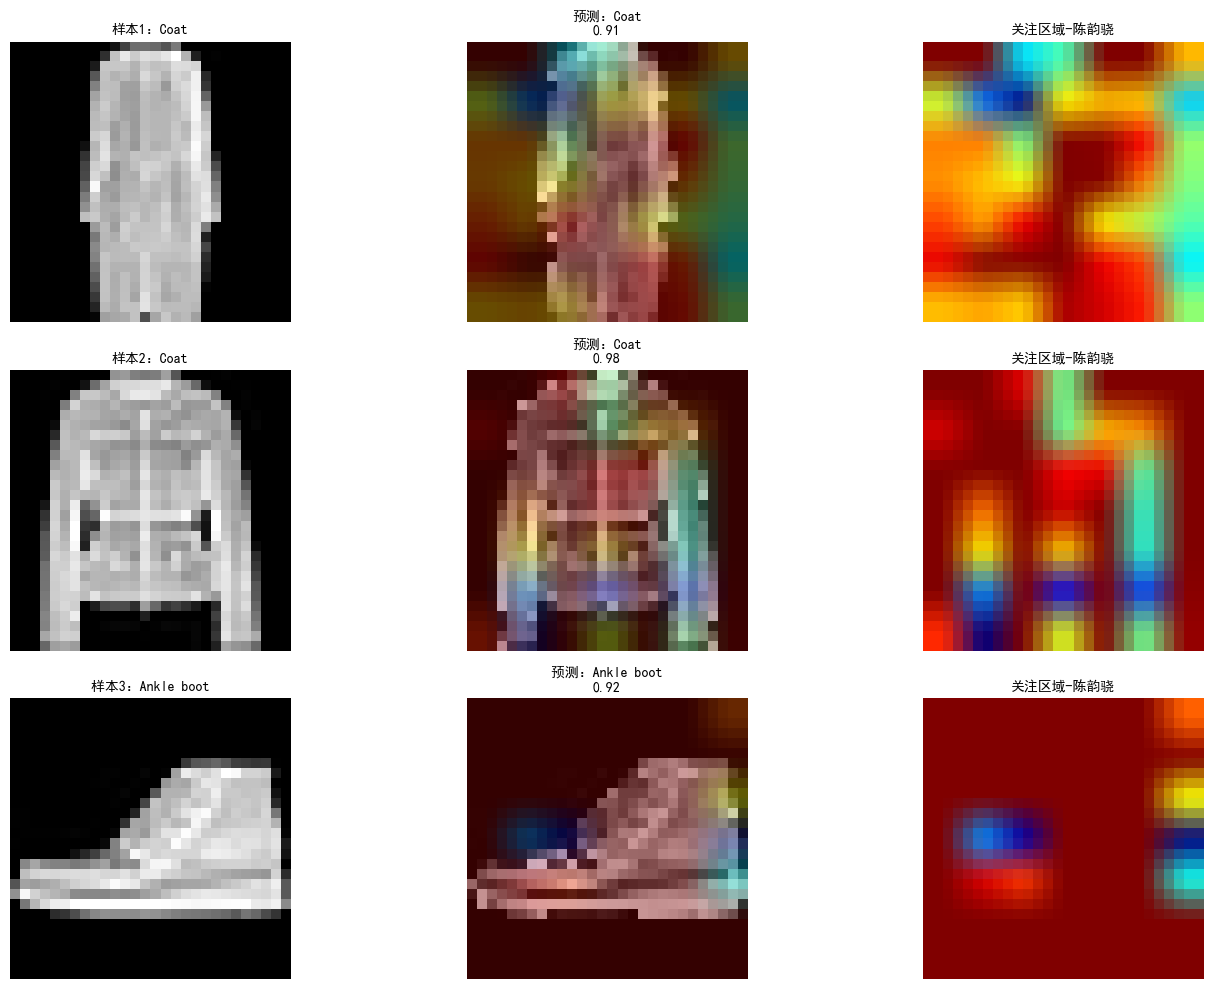

In [72]:
# 单元格12：Grad-CAM可视化（维度兼容版）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def generate_attention_map(gradcam, img_tensor, pred_label):
    """生成标准化热图并确保正确维度"""
    # 生成原始热图 (1, H, W)
    heatmap = gradcam(img_tensor.unsqueeze(0).to(device), pred_label)
    
    # 移除批次维度并调整范围
    heatmap = heatmap.squeeze()  # 变为 (H, W)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    # 转换为3通道热图 (H, W, 3)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    return heatmap

# 1. 初始化GradCAM
target_layer = next(module for name, module in model.named_modules() 
                  if name == 'features.18')
gradcam = GradCAM(model, target_layer)

# 2. 主详细分析（固定样本）
main_idx = 5
main_img, true_label = test_data[main_idx]

with torch.no_grad():
    output = model(main_img.unsqueeze(0).to(device))
    pred_prob, pred_label = torch.max(torch.softmax(output, dim=1), 1)
    pred_prob = pred_prob.item()
    pred_label = pred_label.item()

# 生成可视化元素
heatmap = generate_attention_map(gradcam, main_img, pred_label)
img = main_img.squeeze().cpu().numpy()

# 转换原始图像为3通道 (H, W) -> (H, W, 3)
if len(img.shape) == 2:
    img_rgb = np.stack([img]*3, axis=-1)
else:
    img_rgb = img.transpose(1, 2, 0)  # (C,H,W) -> (H,W,C)
img_uint8 = (img_rgb * 255).astype(np.uint8)

# 尺寸自动对齐（双重保障）
if img_uint8.shape[:2] != heatmap.shape[:2]:
    heatmap = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))

# 图像叠加
superimposed_img = cv2.addWeighted(
    img_uint8, 0.6,
    heatmap, 0.4,
    0
)

# 三列布局
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title(f'样本{main_idx}：真实类别\n{class_names[true_label]}', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(superimposed_img)
plt.title(f'模型预测：{class_names[pred_label]}\n置信度：{pred_prob:.2f}', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(heatmap)
plt.title('Grad-CAM热力图\n关注区域-陈韵骁', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

# 3. 多样本对比（3×3网格）
selected_indices = np.random.choice(len(test_data), 3, replace=False)
plt.figure(figsize=(15, 10))

for row, idx in enumerate(selected_indices):
    sample_img, true_label = test_data[idx]
    
    with torch.no_grad():
        output = model(sample_img.unsqueeze(0).to(device))
        pred_prob, pred_label = torch.max(torch.softmax(output, dim=1), 1)
        pred_prob = pred_prob.item()
        pred_label = pred_label.item()
    
    # 生成可视化元素
    heatmap = generate_attention_map(gradcam, sample_img, pred_label)
    img = sample_img.squeeze().cpu().numpy()
    
    # 处理单通道图像
    if len(img.shape) == 2:
        img_rgb = np.stack([img]*3, axis=-1)
    else:
        img_rgb = img.transpose(1, 2, 0)
    img_uint8 = (img_rgb * 255).astype(np.uint8)
    
    # 尺寸自动对齐
    if img_uint8.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    
    superimposed_img = cv2.addWeighted(
        img_uint8, 0.6,
        heatmap, 0.4,
        0
    )
    
    # 绘制三列
    plt.subplot(3, 3, row*3+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'样本{row+1}：{class_names[true_label]}', fontsize=10)
    plt.axis('off')
    
    plt.subplot(3, 3, row*3+2)
    plt.imshow(superimposed_img)
    plt.title(f'预测：{class_names[pred_label]}\n{pred_prob:.2f}', fontsize=10)
    plt.axis('off')
    
    plt.subplot(3, 3, row*3+3)
    plt.imshow(heatmap)
    plt.title('关注区域-陈韵骁', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 13. 特征空间分析
- **技术**：t-SNE降维（perplexity=30）
- **采样**：1000个测试样本（加速计算）
- **可视化**：
  - 2D散点图（10类别不同颜色）
  - 图例交互显示
- **保存**：`tsne_features.npz`包含降维结果

特征提取中: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.56it/s]


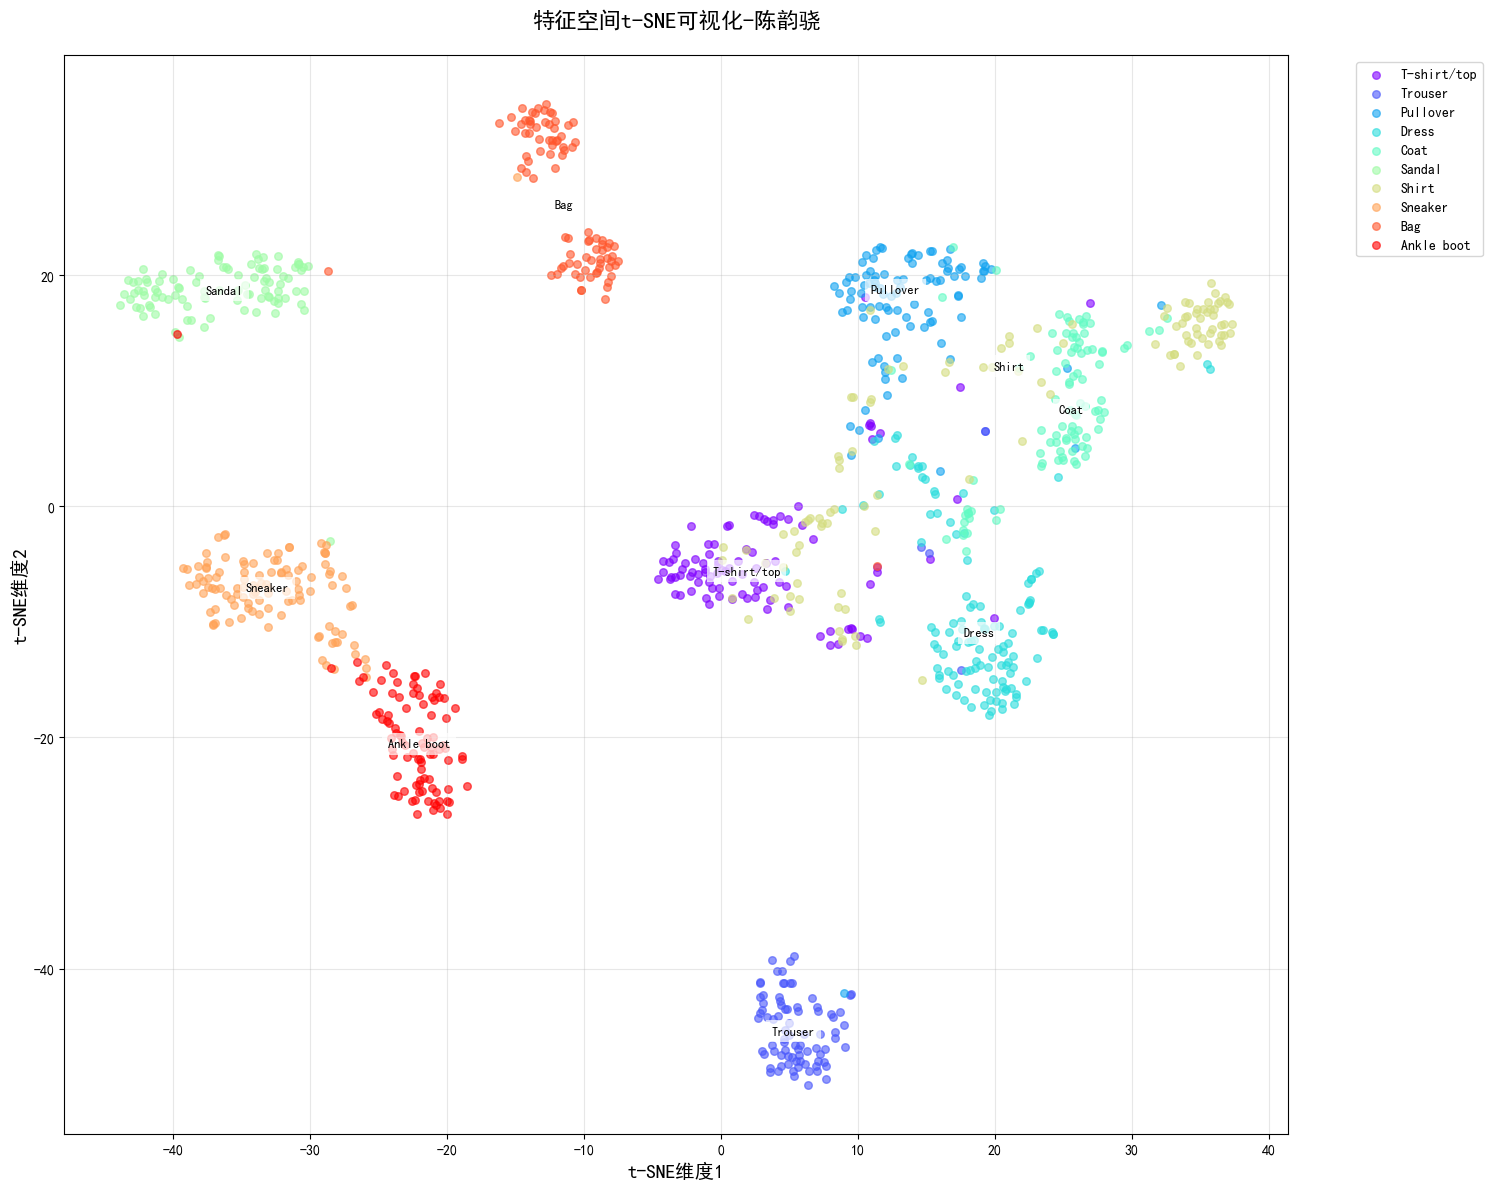

t-SNE特征已保存，包含中文类别标签-陈韵骁


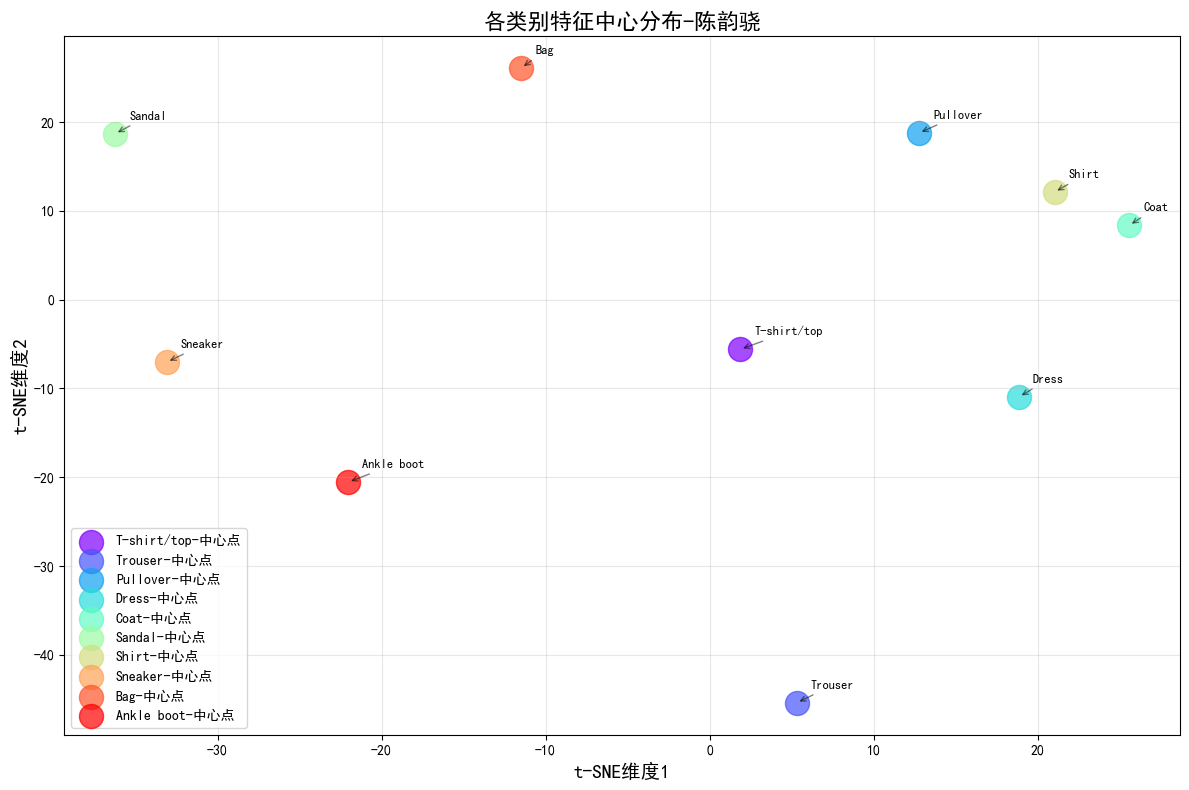

In [74]:
# 单元格13：特征空间可视化（t-SNE）- 中文标题版
from sklearn.manifold import TSNE
from matplotlib import cm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def extract_features(model, data_loader):
    """特征提取函数"""
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc='特征提取中'):
            images = images.to(device)
            features.append(model.features(images).flatten(1).cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)

# 1. 特征提取（1000个随机样本）
sample_indices = np.random.choice(len(test_data), 1000, replace=False)
sample_loader = DataLoader(
    torch.utils.data.Subset(test_data, sample_indices),
    batch_size=128,
    shuffle=False
)
features, true_labels = extract_features(model, sample_loader)

# 2. t-SNE降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features)

# 3. 可视化
plt.figure(figsize=(15, 12))
colors = cm.rainbow(np.linspace(0, 1, len(class_names)))

for i, (color, name) in enumerate(zip(colors, class_names)):
    mask = (true_labels == i)
    plt.scatter(
        features_tsne[mask, 0], 
        features_tsne[mask, 1],
        color=color,
        label=name,
        alpha=0.6,
        s=30
    )

plt.title('特征空间t-SNE可视化-陈韵骁', fontsize=16, pad=20)
plt.xlabel('t-SNE维度1', fontsize=14)
plt.ylabel('t-SNE维度2', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(alpha=0.3)

# 添加类别分布注释
for i, name in enumerate(class_names):
    class_pos = np.median(features_tsne[true_labels == i], axis=0)
    plt.text(class_pos[0], class_pos[1], name, 
             fontsize=9, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()

# 4. 保存结果（可选）
np.savez('tsne_features.npz',
         features=features_tsne,
         labels=true_labels,
         class_names=class_names)
print("t-SNE特征已保存，包含中文类别标签-陈韵骁")

# 5. 新增类别中心可视化
plt.figure(figsize=(12, 8))
for i, name in enumerate(class_names):
    class_pos = np.median(features_tsne[true_labels == i], axis=0)
    plt.scatter(class_pos[0], class_pos[1], 
                color=colors[i], s=300, alpha=0.7,
                label=f'{name}-中心点')
    
plt.title('各类别特征中心分布-陈韵骁', fontsize=16)
plt.xlabel('t-SNE维度1', fontsize=14)
plt.ylabel('t-SNE维度2', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# 添加箭头标注
for i, name in enumerate(class_names):
    class_pos = np.median(features_tsne[true_labels == i], axis=0)
    plt.annotate(name, xy=class_pos, xytext=(10, 10),
                 textcoords='offset points', fontsize=9,
                 arrowprops=dict(arrowstyle="->", alpha=0.5))

plt.tight_layout()
plt.show()